# Classification with RESET-reconstructed events

In this notebook we read in the prepared data, construct and train the DNN, and then evaluate its performance for the classification of RESET-reconstructed events.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy  as np
import random as rd
import tables as tb
import h5py
import tensorflow as tf

from matplotlib.patches         import Ellipse
from __future__  import print_function
from scipy.stats import threshold

# Keras imports
import keras.backend.tensorflow_backend as K
from keras.models               import Model, load_model, Sequential
from keras.layers               import Input, Dense, MaxPooling3D, AveragePooling3D, Convolution3D, Activation, Dropout, merge
from keras.layers.normalization import BatchNormalization
from keras.optimizers           import SGD, Adam, Nadam         
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core          import Flatten
from keras                      import callbacks
from keras.regularizers         import l2

Using TensorFlow backend.


# Variable definitions
Here we define key variables to be used throughout the notebook.

In [2]:
# data dimensions
xdim = 40
ydim = 40
vsizeX = 10.
vsizeY = 10.

# data location and training/test file numbers
data_fname_si = "/Users/jrenner/IFIC/jerenner/next-deeplearning-analysis/data/conv_reset_bb_v10_iter100.h5"
data_fname_bg = "/Users/jrenner/IFIC/jerenner/next-deeplearning-analysis/data/conv_reset_se_v10_iter100.h5"

## Function definitions

### Data input functions

In [3]:
# define the function to read the data from multiple files
def read_data(dataf_si, dataf_bg):
    """Reads all events from the files with the specified file numbers."""
    
    # get the maps and the labels from the data files
    indata_si = tb.open_file(dataf_si, 'r')
    maps_si = np.reshape(indata_si.root.maps,(len(indata_si.root.maps), xdim, ydim))
    labels_si = np.array(indata_si.root.coords,dtype=np.float32)
    indata_si.close()
    print("Read {0} signal events".format(len(maps_si)))
    
    indata_bg = tb.open_file(dataf_bg, 'r')
    maps_bg = np.reshape(indata_bg.root.maps,(len(indata_bg.root.maps), xdim, ydim))
    labels_bg = np.array(indata_bg.root.coords,dtype=np.float32)
    indata_bg.close()
    print("Read {0} background events".format(len(maps_bg)))
    
    # concatenate the datasets
    x_ = np.concatenate([maps_si, maps_bg])
    y_ = np.concatenate([labels_si, labels_bg])

    # reshape the maps to add the extra channel dimension and the labels to fit in the interval [0,1]
    x_ = np.reshape(x_, (len(x_), xdim, ydim, 1))
    
    print("Finished reading data.")
    return x_,y_

### Neural network models
These functions should define and return a Keras model object.

In [4]:
# define a fully-connected neural network with 64 hidden neurons and 1 readout neuron
def model_FC(inputs):

    model = Sequential()
    model.add(Flatten(input_shape=(xdim,ydim,1)))
    model.add(Dense(output_dim=1024,activation='relu')) 
    model.add(Dense(output_dim=512,  activation='relu'))
    model.add(Dense(output_dim=256,  activation='relu'))
    model.add(Dense(output_dim=128, activation='relu'))
    #model.add(Dense(output_dim=64, activation='relu'))
    model.add(Dense(output_dim=1,    activation='relu'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Nadam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=1e-08, schedule_decay=0.01),
                                  metrics=['accuracy']) 
    return model

In [26]:
def model_CNN(inputs):
    
    cinputs = Conv2D(32, (8, 8), padding='same', strides=(2, 2), activation='relu', kernel_initializer='lecun_uniform', kernel_regularizer=l2(0.01))(inputs)
    cinputs = MaxPooling2D(pool_size=(5, 5), data_format=None, padding="same", strides=(5, 5))(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = Conv2D(64, (2, 2), padding='same', strides=(1, 1), activation='relu', kernel_initializer='lecun_uniform', kernel_regularizer=l2(0.01))(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = MaxPooling2D(pool_size=(2, 2), data_format=None, padding="same", strides=(2, 2))(cinputs)
    cinputs = Conv2D(128, (1, 1), padding='same', strides=(1, 1), activation='relu', kernel_initializer='lecun_uniform', kernel_regularizer=l2(0.01))(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    f1 = Flatten()(cinputs)
    f1 = Dense(units=16, activation='relu', kernel_initializer='lecun_uniform', kernel_regularizer=l2(0.008))(f1)
    f1 = Dropout(.6)(f1)

    inc_output = Dense(units=1, activation='sigmoid', kernel_initializer='lecun_uniform', kernel_regularizer=l2(0.001))(f1)
    model = Model(inputs, inc_output)
    
    model.compile(loss='binary_crossentropy',
                      optimizer=Nadam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                      epsilon=1e-08, schedule_decay=0.1), metrics=['accuracy'])
    
    return model

### Plotting functions

In [27]:
# plot a single RESET event
# -- carried over from NEW_kr_diff_mc_train.ipynb
def NEW_SiPM_map_plot(xarr, normalize=True):
    """
    Plots a SiPM map in the NEW Geometry
    xarr is a NEW sipm map, yarr the pair of coordinates the map corresponds to
    """
    if normalize:
        probs = (xarr - np.min(xarr))
        probs /= np.max(probs)
    else: 
        probs = xarr

    fig = plt.figure()
    fig.set_figheight(5.0)
    fig.set_figwidth(7.5)

    sp1 = plt.imshow(probs, extent=[-195., 195., -195., 195.], interpolation='none', aspect='auto', origin='lower')
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    cbp1 = plt.colorbar(sp1);
    cbp1.set_label('Normalized Energy')

## Load in the data

In [7]:
# read in the training data
x_train, y_train = read_data(data_fname_si, data_fname_bg)

Read 113581 signal events
Read 113887 background events
Finished reading data.


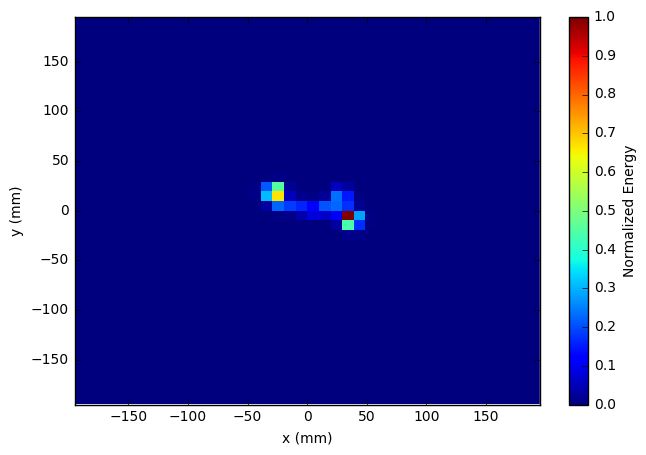

In [28]:
# plot one slice of one event with corresponding true point
NEW_SiPM_map_plot(x_train[4,:,:,0])

## Define and train the DNN

In [29]:
# set load_model to true and specify the file to load in a previously defined/trained model
load_model = False
mfile = 'models/conv3d_classifier.h5'

if(load_model):
    model = load_model(mfile)
else:
    
    # otherwise define the model
    inputs = Input(shape=(xdim, ydim, 1))
    model = model_CNN(inputs)
    
    # define callbacks (actions to be taken after each epoch of training)
    file_lbl = "{epoch:02d}-{loss:.4f}"
    filepath="weights-{0}.h5".format(file_lbl)
    checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    lcallbacks = [checkpoint]            
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 20, 20, 32)        2080      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 4, 4, 32)          128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 64)          8256      
_________________________________________________________________
batch_normalization_26 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 2, 2, 64)          0         
__________

In [30]:
# train the model
hist = model.fit(x_train, y_train, shuffle=True, epochs=60, batch_size=100, verbose=1, validation_split=0.05, callbacks=lcallbacks)

Train on 216094 samples, validate on 11374 samples
Epoch 1/60
216094/216094 [==============================] - 169s - loss: 0.8268 - acc: 0.6741 - val_loss: 0.6525 - val_acc: 0.5387
Epoch 2/60
 48400/216094 [=====>........................] - ETA: 126s - loss: 0.6152 - acc: 0.7046

KeyboardInterrupt: 

## Test the trained model

In [ ]:
# read in the test data
x_test, y_test = read_data(data_location, run_name, 3, 5)

In [ ]:
# compute the predictions
loss_and_metrics = model.evaluate(x_test, y_test);
y_pred = model.predict(x_test, batch_size=100, verbose=0)
print(loss_and_metrics)